In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy
import json
# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    Model
)
from gammapy.estimators import ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit
import import_dataset_helper

In [2]:
'''colors_case = ['darkorange', 'red', 'maroon', 'grey', 'grey']
fmts = ['^', 'o',  'x', 's']
color_overall_standard = 'green'
label = 'Correct Est. ($\mu$ +  $\sigma$)'
labelunder = "Under Est. ($\mu$ + 0.5 $\cdot$ $\sigma$)"
labelover =  "Over Est. ($\mu$ + 2 $\cdot$ $\sigma$)"
labelstandard = "No Nuisance Par. "'''

# standard and Nuisance
colors_case = ['green', 'red']
fmts = ['o', 'x']
labels = ["Standard", "With Nuisance Par."]
colors_e = ['purple' , 'blue', 'green', 'teal', 'crimson' , 'yellow']

#path_local_repo_saturn = '/home/saturn/caph/mppi045h/Nuisance_Asimov_Datasets'
#models = Models.read("1a-Source_models.yaml")
outputfolder = 'output/data_asimov_tests'


with open('1-amplitudes_where_sys_smaller.json', 'r') as fp:
    a_threshold  = json.load(fp)
print(a_threshold)

{'pointsource_center': '1e-12', 'gaussiansource_center': '1e-12', 'largegaussiansource_center': '1e-10'}


## Nuisance

In [3]:
i_start = 6
i_end = 12

def get_circ_mask(geom , radius ):
    center_coord = geom.center_skydir
    #radius = 2*u.deg
    skyregion = CircleSkyRegion(center=center_coord, radius = radius)
    map_mask= Map.from_geom(geom, 
                                data=geom.region_mask([skyregion], inside=True).data)
    return map_mask

def compute_quality_value(dataset, radius):
    input_ =  get_data_to_plot(dataset,     'counts', i_start, i_end, radius)
    recovered_ = get_data_to_plot(dataset,   'npred', i_start, i_end, radius)
    p = compute_p_value(input_, recovered_)
    return p


def compute_quality_values(datasets, radius):
    ps = []
    for dataset in datasets:
        p = compute_quality_value(dataset, radius)
        ps.append(p)
    return ps

from scipy.stats import ks_2samp

def get_data_to_plot(dataset,type_, i_start, i_end, radius):
    if type_ =='npred':
        data= dataset.npred() 
    
    if type_ =='counts':
        data= dataset.counts 
        
    data *= get_circ_mask(data.geom , radius*u.deg )
    data = data.slice_by_idx(dict(energy = slice(i_start, i_end)))
    data = data.data.flatten()
    data = [d for d in data if d != 0]    
        
    return data



def compute_p_value(input_, recovered_ ):
    KS, p = ks_2samp(input_, recovered_, alternative='two-sided',)
    return p


In [4]:
def create_MapDataset(dataset):
    
    mapdatset = MapDataset(models=None, 
                           counts=None, 
                           exposure=dataset.exposure, 
                           background=dataset.background, 
                           psf=dataset.psf, 
                           edisp=dataset.edisp, 
                           mask_safe=dataset.mask_safe, 
                           mask_fit=dataset.mask_fit, 
                           gti=dataset.gti, 
                           meta_table=dataset.meta_table, 
                           name="basic")
    
    bkg_model = FoVBackgroundModel(dataset_name=mapdatset.name) 
    #bkg_model.parameters['norm'].value = dataset.background_model.parameters['norm'].value
    #bkg_model.parameters['tilt'].value = dataset.background_model.parameters['tilt'].value
    models = Models([dataset.models[0].copy()])
    models.append(bkg_model)
    mapdatset.models = models
    mapdatset.counts = dataset.counts
    mapdatset.background = dataset.npred_background()
    return mapdatset

def compute_residual(dataset, energy_edges ,  max_ = None, radius = 1.0*u.deg,  ):
    
    estimator = ExcessMapEstimator( correlation_radius=radius , 
                                       energy_edges=energy_edges) 
    result = estimator.run(dataset) 
    residual = result["sqrt_ts"]#.slice_by_idx(dict(energy=slice(e,e+1)))

    if max_ is None:
        vmax = np.nanmax(np.abs(residual.data))
    else:
        vmax = max_
    return residual

In [5]:
def plot_residuals(res, title, max_):
    data_zero = res#.slice_by_idx(dict(energy=slice(i_start,i_end)))
    if max_ is None:
        max_ = np.nanmax(np.abs(data_zero.data))
    axs = data_zero.plot_grid(add_cbar = 1,cmap = 'coolwarm', vmin = -max_, vmax = max_);
    axs = axs.flatten()
    #data_zero.data = np.nan_to_num(data_zero.data)
    mean = np.nanmean(data_zero, axis=2)
    mean = np.nanmean(mean, axis = 1)
    std = np.nanstd(data_zero, axis=2)
    std = np.nanstd(std, axis = 1)
    for i in range(len(mean)):
        axs.flatten()[i].text(10,35, f'{mean[i]:.2} $\pm$ {std[i]:.2}', fontsize = 12)
    plt.suptitle(title, 
                 fontsize = 14, y=1.01)
    return max_

## Load Single Amplitudes

In [6]:
def get_finished_rnds(amplitude):
    outputfile = '/OOutput'+str(amplitude.value)+'.json'

    with open(outputfolder+outputfile, 'r') as f:
        data = json.load(f)
    rnds = list(data.keys()) 
    rnd_started, rnd_finished = [], []
    for i in range(len(rnds)):
        try:
            data[str(rnds[i])]['result'] 
            rnd_finished.append(int(rnds[i]))
        except:
            None
    return rnd_finished

In [7]:
i_start,i_end = 6,10
elist = np.linspace(i_start,i_end, i_end-i_start )



0
1
2
3
4
5
6
7


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3997/3665614159.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

0
1
2
3
4
5
6
7
8
20
21
22
23
24
25
26
27
28
40
41
42
43
44
45
46
47
48
60
61
62
63
64
65
66
67
68
69
80
81
82
83
84
85
86
87
88
89


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3997/3665614159.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

0
1
2
3
4
5
6
7
8
20
21
22
23
24
25
26
40
41
42
43
44
45
46
60
61
62
63
64
65
66
67
68
80
81
82
83
84
85
86
87
88
89


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3997/3665614159.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
40
41
42
43
44
45
46
47
48
49
90
91
92
93
94
95
96
97
98
99


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3997/3665614159.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

[array([0.51692057, 0.33396548, 0.35424678, 0.63115625, 0.82941765,
       0.76408481, 0.62218815, 0.39715389]), array([0.2047085 , 0.17829469, 0.36118253, 0.62218815, 0.80569218,
       0.77258163, 0.65810727, 0.38250936, 0.22894055, 0.45098261,
       0.65810727, 0.50004189, 0.62218815, 0.28377526, 0.90531099,
       0.5688528 , 0.53403048, 0.66709033, 0.60430282, 0.36118253,
       0.90531099, 0.60430282, 0.75551355, 0.70288075, 0.48341443,
       0.60430282, 0.39715389, 0.80569218, 0.64912059, 0.77258163,
       0.65810727, 0.5688528 , 0.79755937, 0.65810727, 0.53403048,
       0.81371728, 0.86632231, 0.73817362, 0.71176522, 0.32738143,
       0.62218815, 0.37531439, 0.68502476, 0.81371728, 0.11783485,
       0.89926013, 0.79755937]), array([0.14031072, 0.06937992, 0.36118253, 0.64013529, 0.74687434,
       0.78099742, 0.63115625, 0.41974426, 0.08855339, 0.07954294,
       0.63115625, 0.26641294, 0.34739844, 0.18678479, 0.85923507,
       0.30193161, 0.49169559, 0.39715389, 0.79755

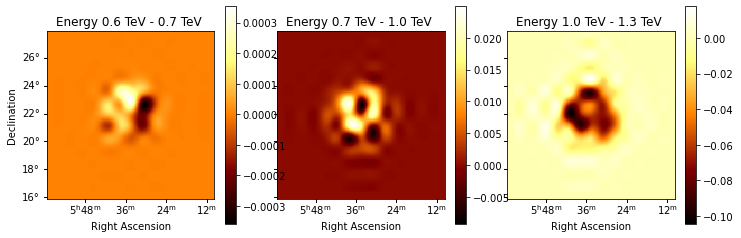

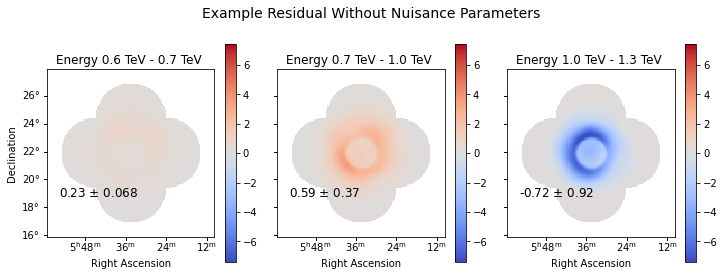

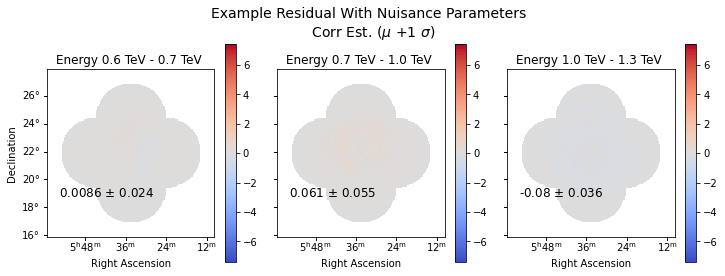

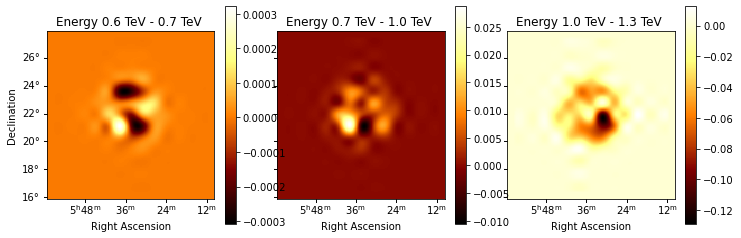

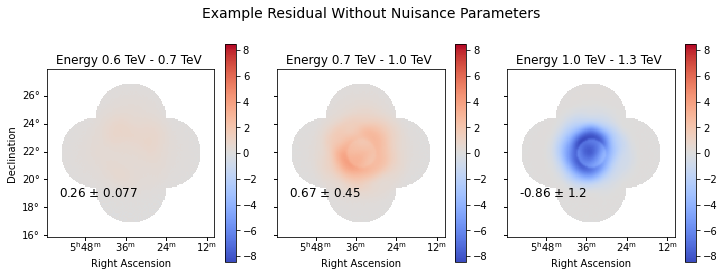

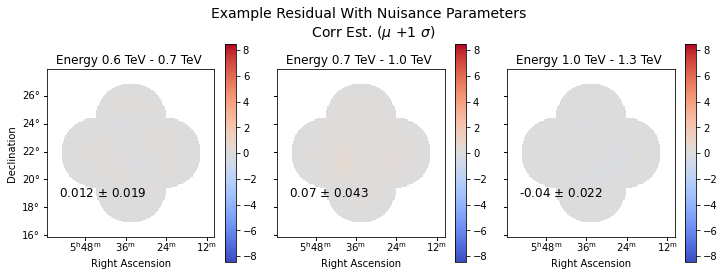

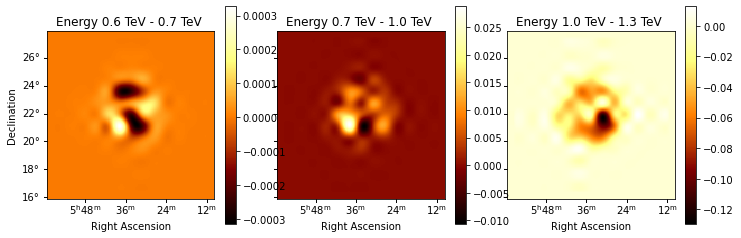

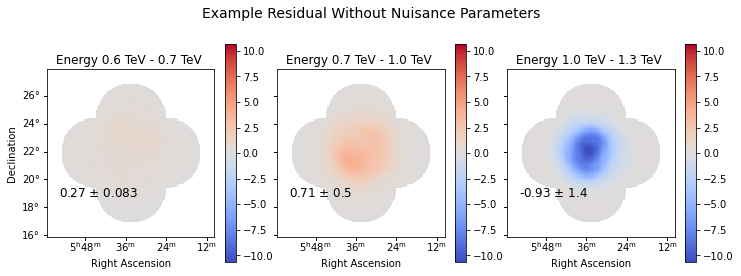

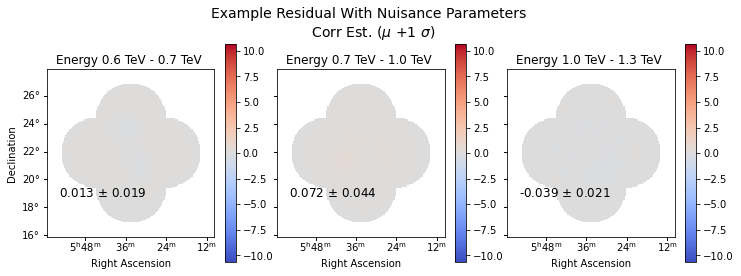

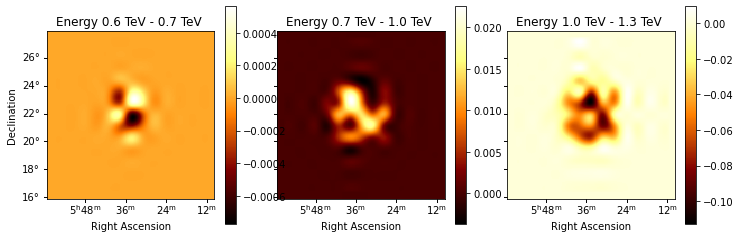

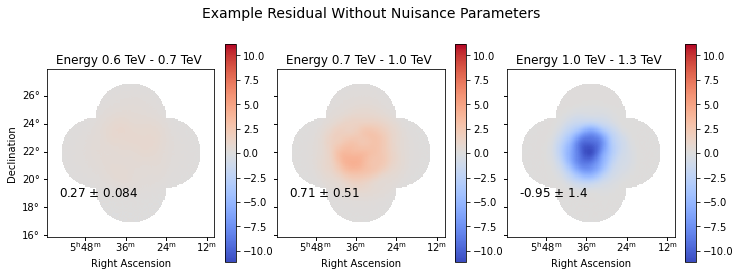

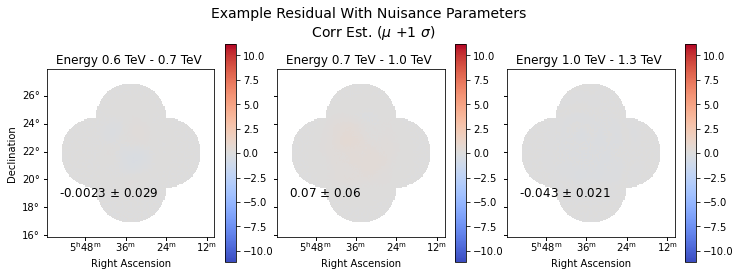

In [8]:
%%time

compute = 0
ams = [1e-9,1e-10,1e-11, 1e-12]

if compute:
    ps_standard_3 = []
    ps_N_3 = []
    ps_standard_03 = []
    ps_N_03 = []
    for a in ams:
        amplitude =  a*u.Unit('cm-2 s-1 TeV-1')
        rnds = get_finished_rnds(amplitude)
        analysis_1e9 = import_dataset_helper.analysis('pointsource_center',amplitude,rnds, False)
        kk = -1

        xaxis = analysis_1e9.datasets_standard[1].geoms['geom'].axes[0].center
        energy_edges = analysis_1e9.datasets_standard[kk].counts.geom.axes['energy'].edges[i_start:i_end]


        analysis_1e9.datasets_corr[-1].N_map().slice_by_idx(dict(energy=slice(6,9))).plot_grid(add_cbar =1);

        max_ = plot_residuals(compute_residual(create_MapDataset(analysis_1e9.datasets_standard[0]), energy_edges), 
                              "Example Residual Without Nuisance Parameters", None)

        plot_residuals(compute_residual(create_MapDataset(analysis_1e9.datasets_corr[kk]), energy_edges), 
                       "Example Residual With Nuisance Parameters \n Corr Est. ($\mu$ +1 $\sigma$)", max_)
        #i_end =9
        #tupels = [(analysis_1e9.datasets_corr[i], analysis_1e9.mocked_dataset_s[i], np.nan, np.nan,
        #           analysis_1e9.datasets_under[i],
        #           analysis_1e9.datasets_over[i], analysis_1e9.datasets_standard[i]) 
        #          for i in range(len(analysis_1e9.datasets_corr))]

        #plot_bg_p_value_multiple(tupels, elist, 'npred')

        ps_standard_3.append( np.array(compute_quality_values(analysis_1e9.datasets_standard, 3)))
        ps_N_3.append(np.array(compute_quality_values(analysis_1e9.datasets_corr,3)))
        ps_standard_03.append( np.array(compute_quality_values(analysis_1e9.datasets_standard, 0.3)))
        ps_N_03.append(np.array(compute_quality_values(analysis_1e9.datasets_corr,0.3)))

        results = dict()
        results['ps_N_3'] = [l.tolist() for l in ps_N_3]
        results['ps_N_03'] = [l.tolist() for l in ps_N_03]
        results['ps_standard_3'] = [l.tolist() for l in ps_standard_3]
        results['ps_standard_03'] = [l.tolist() for l in ps_standard_03]

        with open('output/data_asimov_tests/4_p_values.yaml', 'w') as outfile:
            yaml.dump(results, outfile, default_flow_style=False)




    print(ps_standard_3)

In [52]:
read_in = 1
if read_in:
    import yaml
    with open("output/data_asimov_tests/4_p_values.yaml", "r") as stream:
        result = yaml.safe_load(stream)
    ps_standard_3 = result['ps_standard_3'] 
    ps_N_3 = result['ps_N_3'] 
    ps_standard_03 = result['ps_standard_03'] 
    ps_N_03 = result['ps_N_03'] 

## Multiple Nice Plot Fit Quality

In [103]:
def compute_mean(lis):
    return [np.mean(l) for l in lis]

def compute_std(lis):
    return [np.std(l) for l in lis]

def plot_qualities(false_est ):
        fig, ax = plt.subplots(1,1, )#figsize =(10,10))
        ax = [ax]
        fmts = ['o', 'x', ]
        colors = ['green', 'red', "darkorange", "maroon"]
        labels_ = ['Standard', "With Nuisance Par. \n(Corr. Est.)", 
                   "With Nuisance Par. \n(Under Est.)", "With Nuisance Par. \n(Over Est.)"]
        
        
        
        
        ax[0].errorbar(np.array(ams)*1e12*0.8, compute_mean(ps_standard_3),
                           yerr = compute_std(ps_standard_3), fmt =fmts[1], color= colors[0],
                              label = labels_[0])# + '\n (r = 3$^\circ$)')
        ax[0].errorbar(np.array(ams)*1e12* 1., compute_mean(ps_standard_03),
                           yerr = compute_std(ps_standard_03), fmt =fmts[0], color= colors[0],
                      )#   label = labels_[0] + '\n (r = 0.3$^\circ$)')
        ax[0].errorbar(np.array(ams)*1e12*0.8, compute_mean(ps_N_3),
                           yerr = compute_std(ps_N_3), fmt =fmts[1], color= colors[1],
                              label = labels_[1])#+ '\n (r = 3$^\circ$)')
        ax[0].errorbar(np.array(ams)*1e12* 1., compute_mean(ps_N_03),
                           yerr = compute_std(ps_N_03), fmt =fmts[0], color= colors[1],
                      )# label = labels_[1] + '\n (r = 0.3$^\circ$)')
        if false_est:
            ax[0].errorbar(np.array(ams_false_est)*1e12*0.4, compute_mean(ps_N_under_3),
                           yerr = compute_std(ps_N_under_3), fmt =fmts[1], color= colors[2],
                              label = labels_[2])#+ '\n (r = 3$^\circ$)')
            ax[0].errorbar(np.array(ams_false_est)*1e12* 0.6, compute_mean(ps_N_under_03),
                               yerr = compute_std(ps_N_under_03), fmt =fmts[0], color= colors[2]
                          )# label = labels_[2] + '\n (r = 0.3$^\circ$)')
            ax[0].errorbar(np.array(ams_false_est)*1e12*1.2, compute_mean(ps_N_over_3),
                               yerr = compute_std(ps_N_over_3), fmt =fmts[1], color= colors[3],
                                  label = labels_[3] )#+ '\n (r = 3$^\circ$)')
            ax[0].errorbar(np.array(ams_false_est)*1e12* 1.4, compute_mean(ps_N_over_03),
                               yerr = compute_std(ps_N_over_03), fmt =fmts[0], color= colors[3],
                          )  # label = labels_[3] + '\n (r = 0.3$^\circ$)')
               
        ax[0].set_xscale('log')
        ax[0].set_xlabel("Input Amplitudes [$10^{-12}$ cm-2 s-1 TeV-1]")
        ax[0].set_ylabel("P-Value of Model Prediction")
        ax[0].hlines(1, xlim_all[0], xlim_all[1] ,color = "grey")
        ax[0].hlines(0.95, xlim_all[0], xlim_all[1] ,color = "grey")
        ax[0].legend()
        ax[0].set_title("Fit Quality (p-value) - Point Source")
        return fig, ax[0]


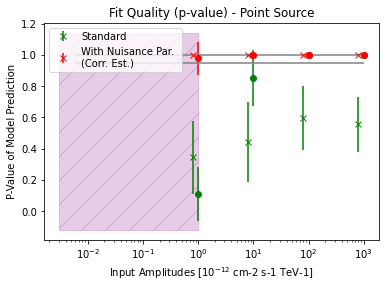

In [104]:

xlim_all = (0.005623413251903491, 1000)

fig , ax1= plot_qualities(False)
ylim = ax1.get_ylim()
ax1.fill_betweenx( y = ylim ,
                 x1 =ax1.get_xlim()[0] , x2=  float(a_threshold['pointsource_center'] )*1e12
                 , color = 'darkmagenta', alpha = 0.2, hatch = '/')
fig.savefig("plots/4_Point_source_pvalue.png")
fig.savefig("plots/4_Point_source_pvalue.pdf")

## False Est. 

0
1
2


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3997/3665614159.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

0
1
2


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3997/3665614159.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

0
1
2


/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)
/tmp/ipykernel_3997/3665614159.py:8: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_zero, axis=2)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

[array([1., 1., 1.]), array([1., 1., 1.]), array([1.        , 0.9999998 , 0.97611415])]
CPU times: user 2min 16s, sys: 1.28 s, total: 2min 18s
Wall time: 2min 18s


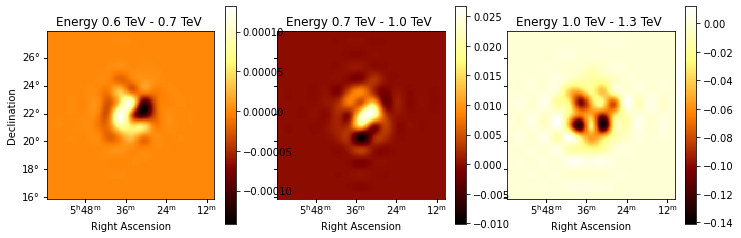

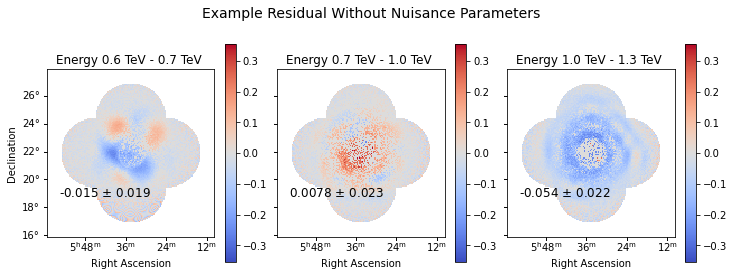

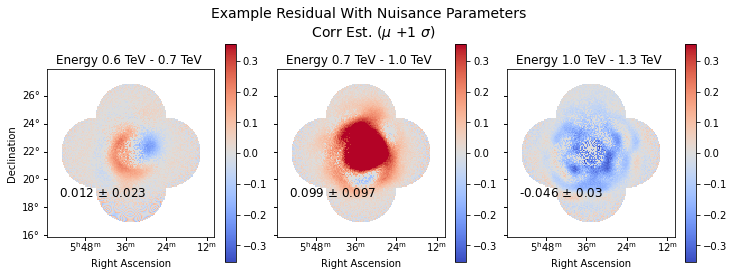

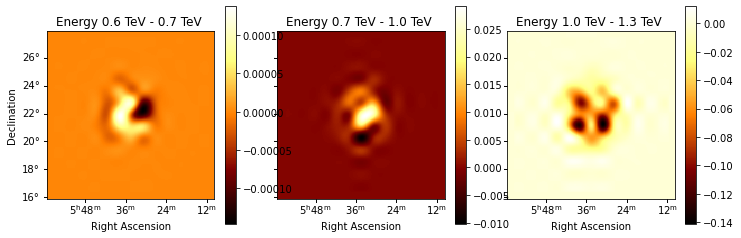

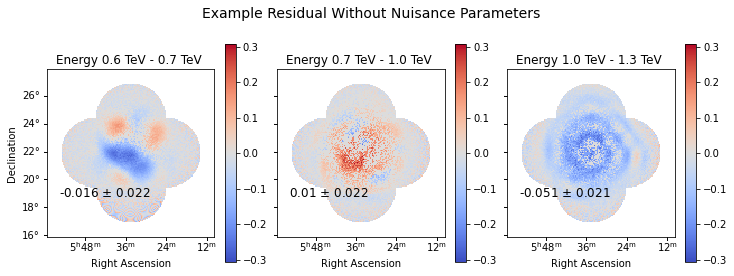

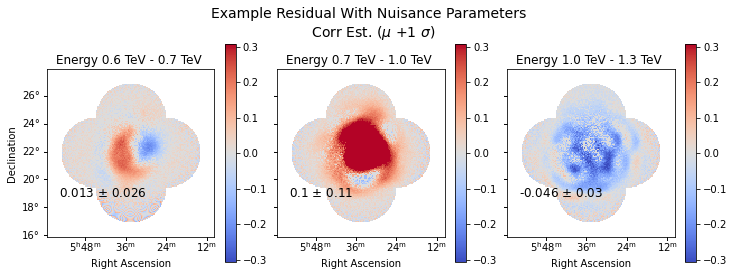

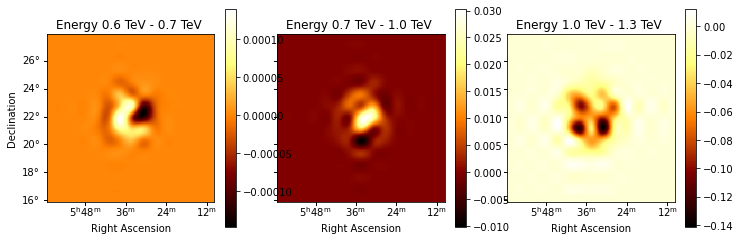

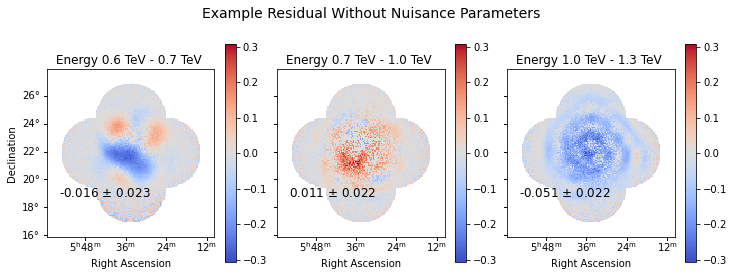

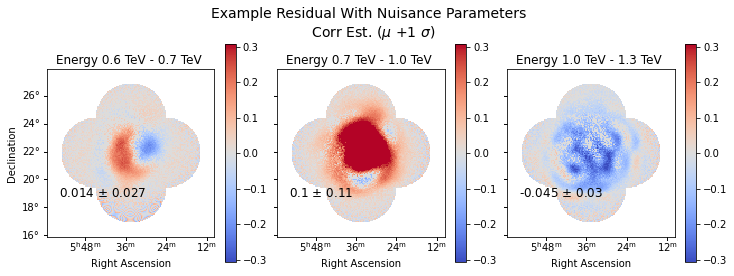

In [57]:
%%time

compute = 1
ams_false_est = [1e-10,1e-11, 1e-12]

if compute:
    ps_N_under_3 = []
    ps_N_over_3 = []
    ps_N_under_03 = []
    ps_N_over_03 = []
    for a in ams_false_est:
        amplitude =  a*u.Unit('cm-2 s-1 TeV-1')
        rnds = get_finished_rnds(amplitude)[:3]
        analysis_1e9 = import_dataset_helper.analysis('pointsource_center',amplitude,rnds, True)
        kk = -1

        xaxis = analysis_1e9.datasets_standard[1].geoms['geom'].axes[0].center
        energy_edges = analysis_1e9.datasets_standard[kk].counts.geom.axes['energy'].edges[i_start:i_end]


        analysis_1e9.datasets_corr[-1].N_map().slice_by_idx(dict(energy=slice(6,9))).plot_grid(add_cbar =1);

        max_ = plot_residuals(compute_residual(create_MapDataset(analysis_1e9.datasets_standard[0]), energy_edges), 
                              "Example Residual Without Nuisance Parameters", None)

        plot_residuals(compute_residual(create_MapDataset(analysis_1e9.datasets_corr[kk]), energy_edges), 
                       "Example Residual With Nuisance Parameters \n Corr Est. ($\mu$ +1 $\sigma$)", max_)

        ps_N_under_3.append( np.array(compute_quality_values(analysis_1e9.datasets_under, 3)))
        ps_N_over_3.append(np.array(compute_quality_values(analysis_1e9.datasets_over,3)))
        ps_N_under_03.append( np.array(compute_quality_values(analysis_1e9.datasets_under, 0.3)))
        ps_N_over_03.append(np.array(compute_quality_values(analysis_1e9.datasets_over,0.3)))

        results = dict()
        results['ps_N_under_3'] = [l.tolist() for l in ps_N_under_3]
        results['ps_N_over_3'] = [l.tolist() for l in ps_N_over_3]
        results['ps_N_under_03'] = [l.tolist() for l in ps_N_under_03]
        results['ps_N_over_03'] = [l.tolist() for l in ps_N_over_03]

        with open('output/data_asimov_tests/4_p_values_false_est.yaml', 'w') as outfile:
            yaml.dump(results, outfile, default_flow_style=False)
    print(ps_N_over_03)

In [61]:
read_in = 1
if read_in:
    import yaml
    with open("output/data_asimov_tests/4_p_values_false_est.yaml", "r") as stream:
        result = yaml.safe_load(stream)
    ps_N_under_3 = result['ps_N_under_3']
    ps_N_over_3 = result['ps_N_over_3']
    ps_N_under_03 = result['ps_N_under_03']
    ps_N_over_03 = result['ps_N_over_03']

In [ ]:

xlim_all = (0.005623413251903491, 1000)

fig , ax1= plot_qualities(True)
ylim = ax1.get_ylim()
ax1.fill_betweenx( y = ylim ,
                 x1 =ax1.get_xlim()[0] , x2=  float(a_threshold['pointsource_center'] )*1e12
                 , color = 'darkmagenta', alpha = 0.2, hatch = '/')
fig.savefig("plots/4_Point_source_pvalue_false_est.png")
fig.savefig("plots/4_Point_source_pvalue_false_est.pdf")